In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from configparser import ConfigParser


def config(filename="database.ini", section="postgresql"):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}

    # Checks to see if section (postgresql) parser exists
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]

    # Returns an error if a parameter is called that is not listed in the initialization file
    else:
        raise Exception(
            "Section {0} not found in the {1} file".format(section, filename)
        )

    return db

<IPython.core.display.Javascript object>

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

<IPython.core.display.Javascript object>

In [4]:
import numpy as np


def create_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

<IPython.core.display.Javascript object>

In [5]:
import numpy as np


def create_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

<IPython.core.display.Javascript object>

In [6]:
import os

# os.environ["CUDA_DEVICE_ORDER"] = "GPU"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15052306722128305437
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8790522664060765582
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2779250688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4818368576881724454
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2301726561350334718
physical_device_desc: "device: XLA_GPU device"
]


<IPython.core.display.Javascript object>

In [7]:
import psycopg2
import pandas as pd

# from conf_db import config

import os

import tensorflow as tf

from tensorflow import keras

import matplotlib.pyplot as plt

# from get_data import create_data

# Establish a connection to the database by creating a cursor object

# Obtain the configuration parameters
params = config("database.ini", "warden_rady")
# Connect to the PostgreSQL database
conn = psycopg2.connect(**params)
# Create a new cursor
cur = conn.cursor()

# A function that takes in a PostgreSQL query and outputs a pandas database
def create_pandas_table(sql_query, database=conn):
    table = pd.read_sql_query(sql_query, database)
    return table


# Utilize the create_pandas_table function to create a Pandas data frame
# Store the data as a variable
dataset1 = create_pandas_table(
    "SELECT time, value FROM history_int WHERE item_id = 30 ORDER BY time"
)
print(len(dataset1))
print(dataset1)

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
cur.close()
conn.close()

5320
                          time  value
0    2017-12-01 00:00:00+00:00      3
1    2017-12-01 01:00:00+00:00     29
2    2017-12-01 02:00:00+00:00     22
3    2017-12-01 03:00:00+00:00     22
4    2017-12-01 04:00:00+00:00     12
...                        ...    ...
5315 2018-07-10 11:00:00+00:00    147
5316 2018-07-10 12:00:00+00:00    140
5317 2018-07-10 13:00:00+00:00    149
5318 2018-07-10 14:00:00+00:00    210
5319 2018-07-10 15:00:00+00:00    128

[5320 rows x 2 columns]


<IPython.core.display.Javascript object>

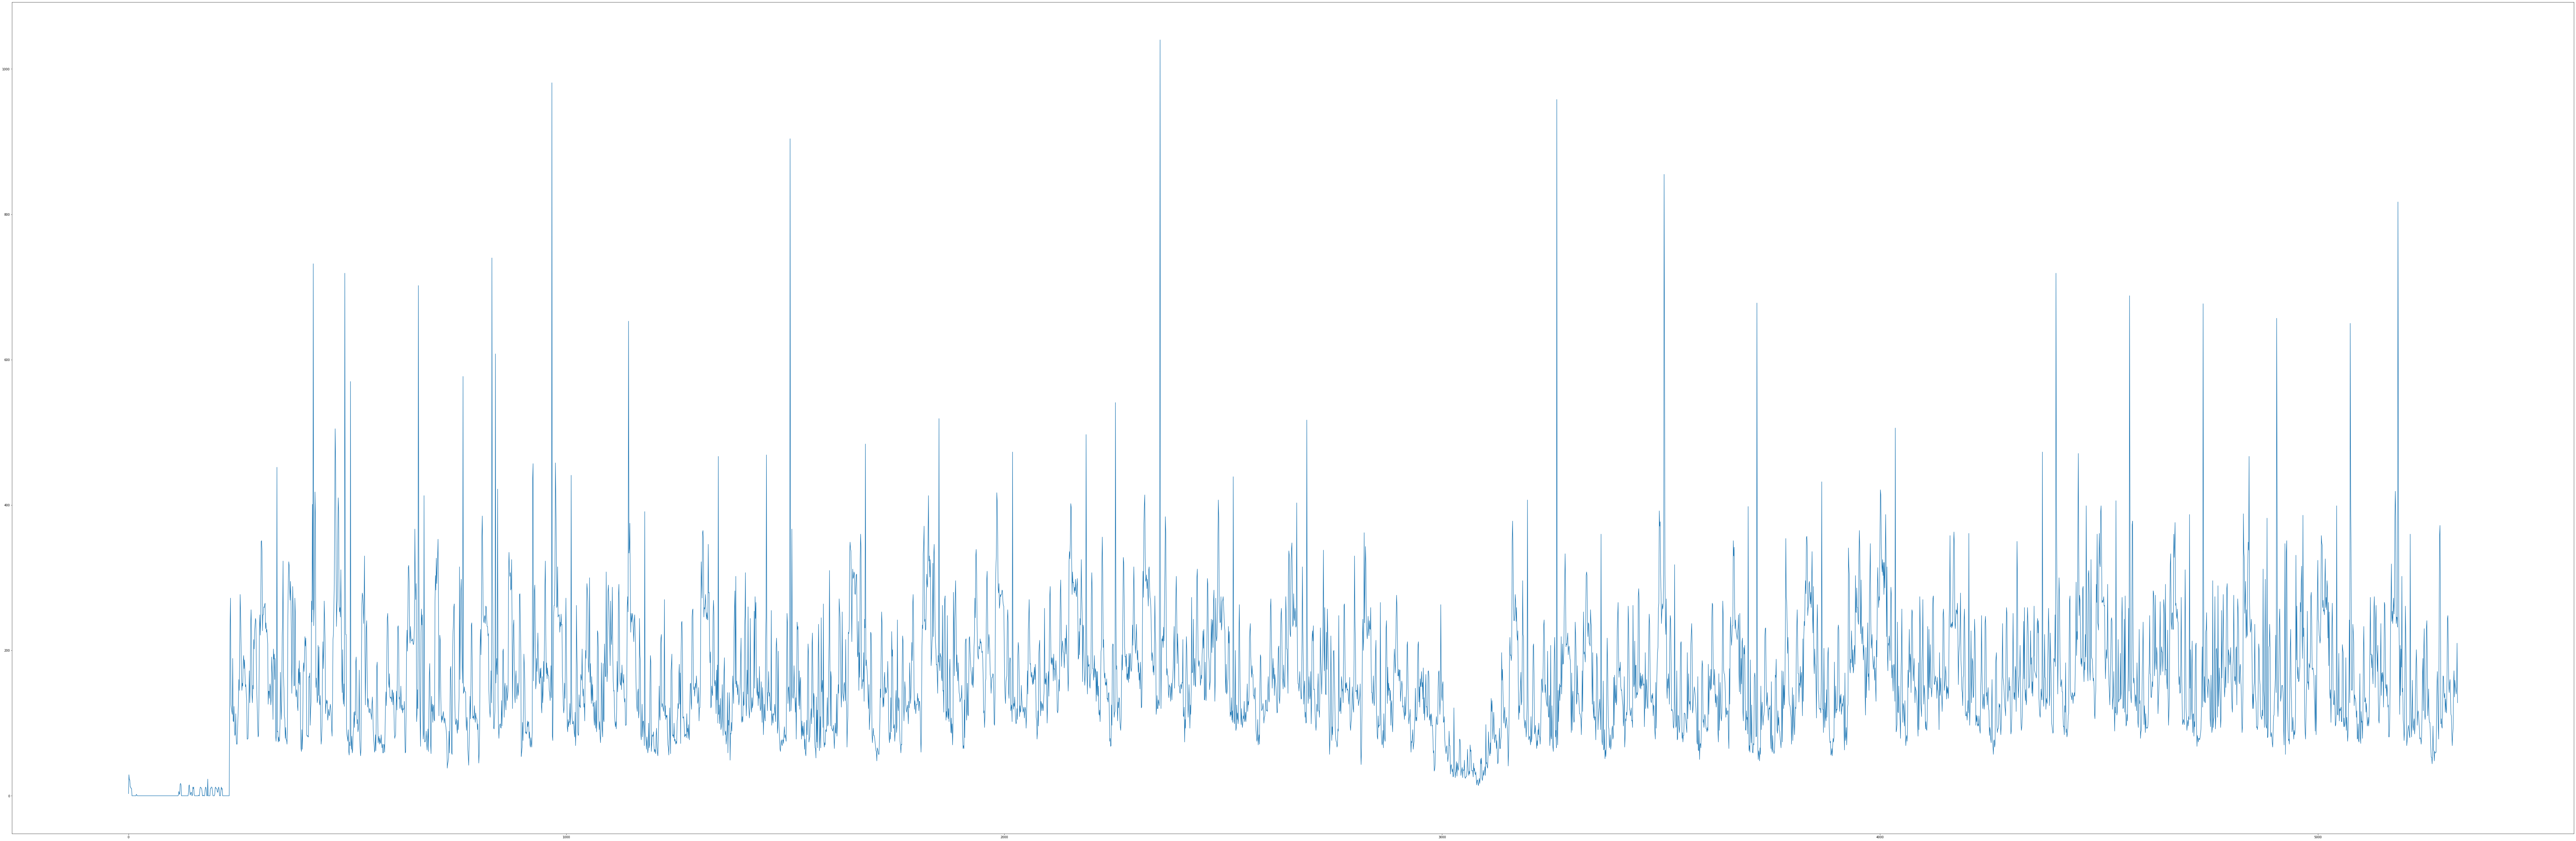

<IPython.core.display.Javascript object>

In [9]:
plt.plot(dataset1.value)
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.rcParams["figure.figsize"] = [150, 50]
plt.show()

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

<IPython.core.display.Javascript object>

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy

# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
# dataframe = read_csv("airline-passengers.csv", usecols=[1], engine="python")
dataframe = dataset1["value"].to_frame()
dataset = dataframe.values
dataset = dataset.astype("float32")
print(dataset)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
# reshape into X=t and Y=t+1
look_back = 500
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX)
print(trainY)

[[  3.]
 [ 29.]
 [ 22.]
 ...
 [149.]
 [210.]
 [128.]]
[[[0.00288462 0.02788462 0.02115385 ... 0.21346153 0.0875     0.07980769]]

 [[0.02788462 0.02115385 0.02115385 ... 0.0875     0.07980769 0.07692308]]

 [[0.02115385 0.02115385 0.01153846 ... 0.07980769 0.07692308 0.07211538]]

 ...

 [[0.03173077 0.02692308 0.03269231 ... 0.09711538 0.09038462 0.08365384]]

 [[0.02692308 0.03269231 0.02884615 ... 0.09038462 0.08365384 0.18942308]]

 [[0.03269231 0.02884615 0.0673077  ... 0.08365384 0.18942308 0.10192308]]]
[0.07692308 0.07211538 0.0875     ... 0.18942308 0.10192308 0.12596154]


<IPython.core.display.Javascript object>

In [13]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(100, activation="tanh"),
        #         tf.keras.layers.Dense(20, activation="tanh"),
        #         tf.keras.layers.Dense(15, activation="tanh"),
        tf.keras.layers.Dense(50, activation="tanh"),
        #         tf.keras.layers.Dense(5, activation="tanh"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

<IPython.core.display.Javascript object>

In [14]:
# for i in range(100):
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2, shuffle=False)
#     model.reset_states()

Train on 3063 samples
Epoch 1/25
3063/3063 - 9s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 2/25
3063/3063 - 8s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 3/25
3063/3063 - 8s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 4/25
3063/3063 - 8s - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 5/25
3063/3063 - 8s - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 6/25
3063/3063 - 8s - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 7/25
3063/3063 - 8s - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 8/25
3063/3063 - 8s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 9/25
3063/3063 - 8s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 10/25
3063/3063 - 8s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 11/25
3063/3063 - 8s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 12/25
3063/3063 - 8s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 13/25
3063/3063 - 8s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 14/25
3063/3063 - 8s - loss: 0.0072 - mean_squared_error: 

<IPython.core.display.Javascript object>

In [15]:
# make predictions
trainPredict = model.predict(trainX)
trainPredict = trainPredict.reshape(-1, 1)
# a = []
# for i in trainPredict:
#     a.append(i[0][0])
# trainPredict = trainPredict = np.ndarray(a)
# trainPredict.reshape(-1, 1)
model.reset_states()
testPredict = model.predict(testX)
testPredict = testPredict.reshape(-1, 1)

<IPython.core.display.Javascript object>

In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

<IPython.core.display.Javascript object>

In [17]:
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

print(trainY)
print(testY)

[[ 80.00000291]
 [ 74.99999933]
 [ 90.99999837]
 ...
 [197.00000745]
 [106.00000133]
 [131.00000369]]
[[172.9999934 ]
 [148.99999485]
 [188.00000412]
 ...
 [140.00000702]
 [148.99999485]
 [209.99999504]]


<IPython.core.display.Javascript object>

In [18]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print("Test Score: %.2f RMSE" % (testScore))

# id 24
# Train Score: 1030.19 RMSE
# Test Score: 1250.47 RMSE

# id 30
# Train Score: 60.00 RMSE
# Test Score: 65.91 RMSE

Train Score: 217.68 RMSE
Test Score: 225.78 RMSE


<IPython.core.display.Javascript object>

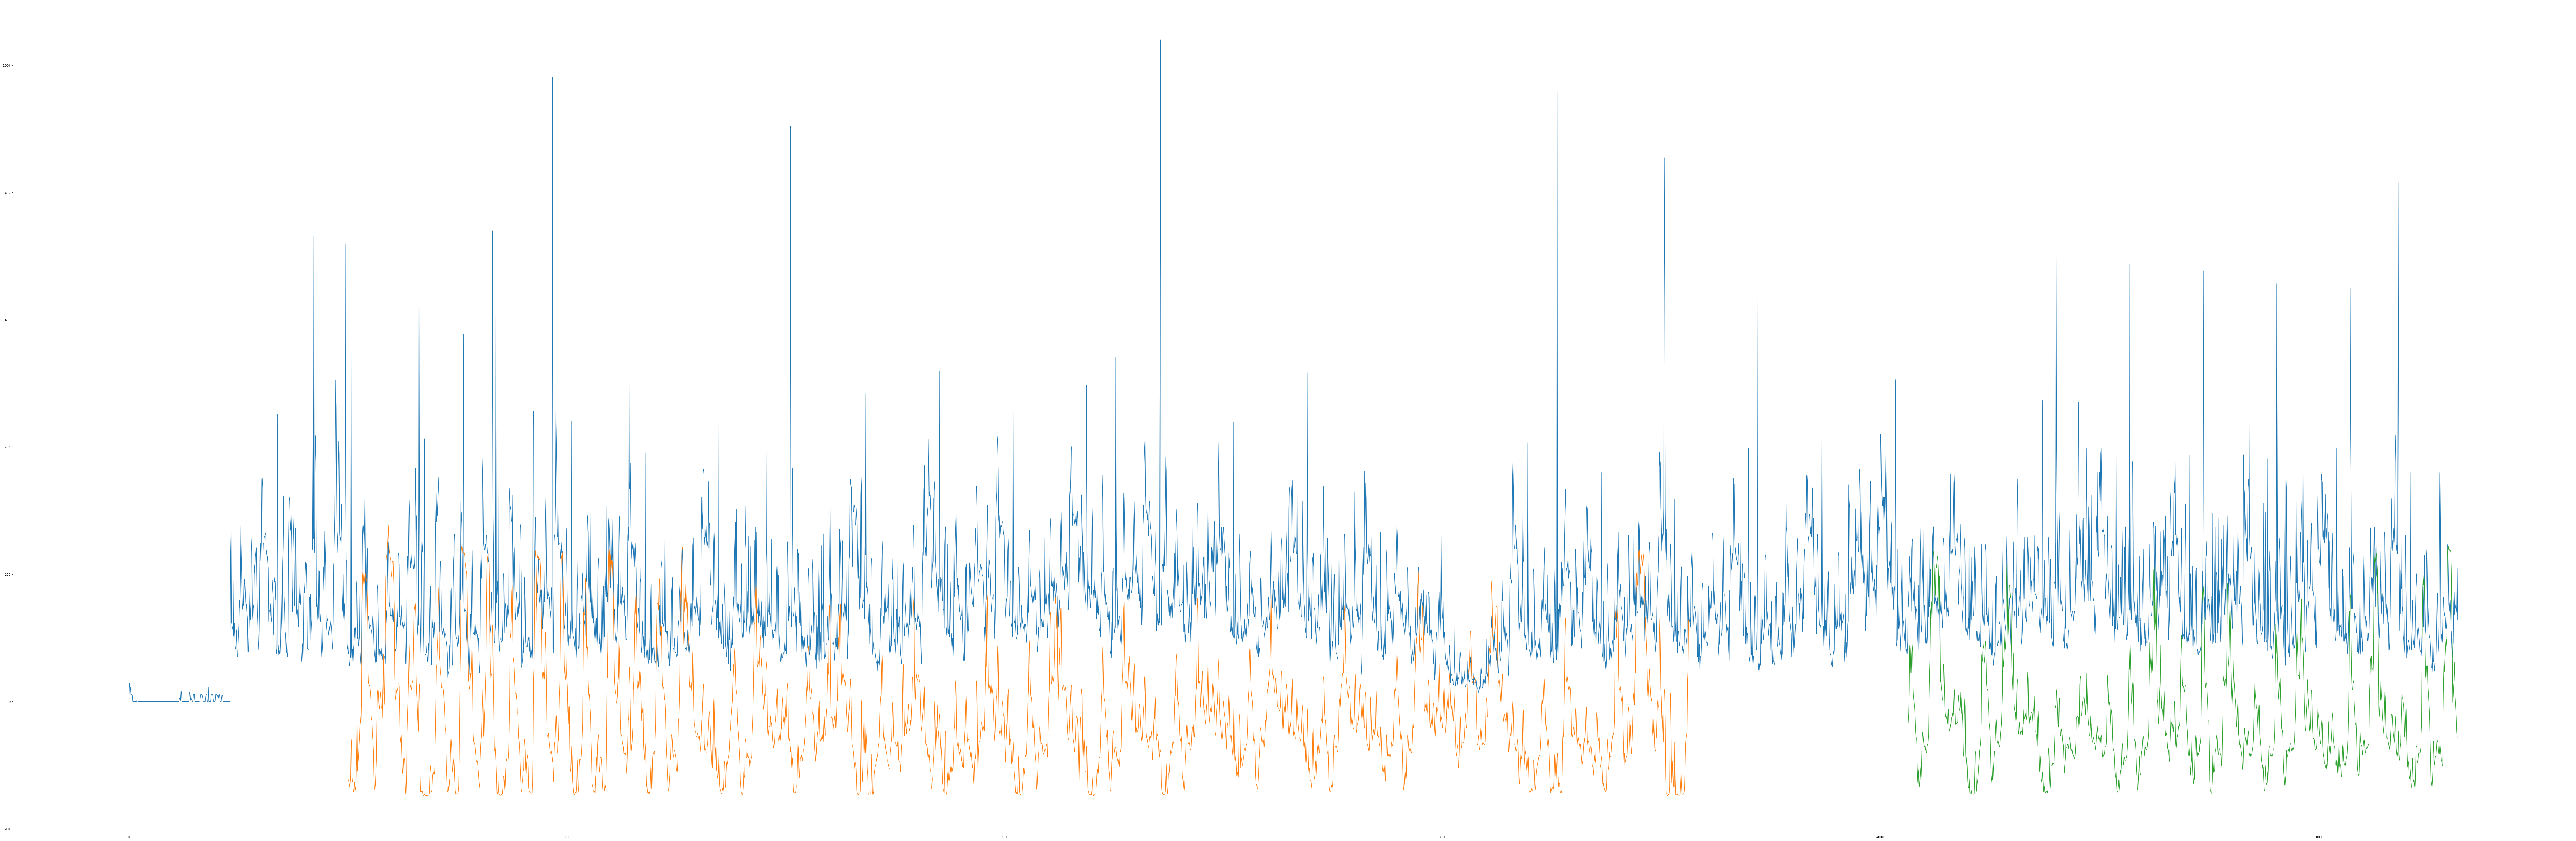

<IPython.core.display.Javascript object>

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict) + look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(trainPredict) + (look_back * 2) + 1 : len(dataset) - 1, :
] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.rcParams["figure.figsize"] = [150, 50]
plt.show()

In [25]:
import plotly.express as px

fig = px.line(
    scaler.inverse_transform(dataset),
    y=0,
    #     y="lifeExp",
    #     title="Life expectancy in Canada",
)
fig.show()

<IPython.core.display.Javascript object>